In [1]:
!pip install update torch==2.0.1
!pip install torchtext==0.15.2
!pip install datasets==2.14.7
!pip install evaluate==0.4.0
!pip install torchvision==0.15.2

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 619.9/619.9 MB 2.5 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 317.1/317.1 MB 2.3 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.8/11.8 MB 93.6 MB/s eta 0:00:00:00:010:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.0/21.0 MB 69.8 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 849.3/849.3 kB 36.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 557.1/557.1 MB 2.9 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 168.4/168.4 MB 9.8 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.6/54.6 MB 30.3 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 102.6/102.6 MB 16.1 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 173.2/173.2 MB 7.0 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 177.1/177.1 MB 6.6 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━

In [2]:
# Завантажуємо англійську та польську моделі spaCy
!python3 -m spacy download en_core_web_sm
!python3 -m spacy download pl_core_news_sm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 85.1 MB/s eta 0:00:0000:0100:01
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 20.2/20.2 MB 52.8 MB/s eta 0:00:0000:0100:01
✔ Download and installation successful
You can now load the package via spacy.load('pl_core_news_sm')


In [3]:
import os
import random
from tqdm.auto import tqdm

import pandas as pd
import numpy as np

import en_core_web_sm
import pl_core_news_sm

import datasets
import torchtext

import torch
import torch.nn as nn
import torch.optim as optim

import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

import warnings
warnings.filterwarnings("ignore")

In [4]:
# Встановлюємо випадковий seed для відтворюваності
seed = 42

random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.backends.cudnn.deterministic = True

## Завантаження та підготовка даних

In [5]:
# Завантажуємо 10% датасету
dataset = datasets.load_dataset("Helsinki-NLP/europarl", "en-pl", split="train[:10%]")

dataset

Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Generating train split:   0%|          | 0/631160 [00:00<?, ? examples/s]

Dataset({
    features: ['translation'],
    num_rows: 63116
})

In [6]:
# Розділімо дані на навчальний та валідаційний набори
train_test_split = dataset.train_test_split(test_size=0.33)

train_data = train_test_split['train']
valid_data = train_test_split['test']

print(train_data[0])

{'translation': {'en': 'At the same time, we have reason to be cautious when it comes to harmonising criminal law, not least in an area which has constitutional implications.', 'pl': 'Jednocześnie mamy powód, by zachować ostrożność w odniesieniu do harmonizacji prawa karnego, dziedzinie, która ma implikacje konstytucyjne, co nie jest bez znaczenia.'}}


In [7]:
with pd.option_context('display.max_colwidth', None):
    example_df = pd.DataFrame(train_data[:5])
    display(example_df)

,translation
0,"{'en': 'At the same time, we have reason to be cautious when it comes to harmonising criminal law, not least in an area which has constitutional implications.', 'pl': 'Jednocześnie mamy powód, by zachować ostrożność w odniesieniu do harmonizacji prawa karnego, dziedzinie, która ma implikacje konstytucyjne, co nie jest bez znaczenia.'}"
1,"{'en': 'in writing. - I voted for the reports in respect of the 2008 draft budget, but I did so heavy in heart because it would appear that the expensive circus that is our regular visits to Strasbourg looks set to continue.', 'pl': 'na piśmie. - Głosowałem za przyjęciem tych sprawozdań w odniesieniu do projektu budżetu na 2008 r., ale uczyniłem to z ciężkim sercem, gdyż wygląda na to, że ta droga ""impreza”, jaką są nasze regularne wizyty w Strasburgu będzie kontynuowana.'}"
2,"{'en': 'Voting time', 'pl': 'Głosowanie'}"
3,"{'en': '11.', 'pl': '11.'}"
4,"{'en': 'Debates on cases of breaches of human rights, democracy and the rule of law (announcement of motions for resolutions tabled): see Minutes', 'pl': 'Debaty na temat przypadków łamania praw człowieka, demokracji i państwa prawa (ogłoszenie złożonych projektów rezolucji): patrz protokół'}"


In [8]:
# Завантажуємо токенізатори spaCy
en_nlp = en_core_web_sm.load()
pl_nlp = pl_core_news_sm.load()

In [9]:
def tokenize_example(    
    example,
    en_nlp,
    pl_nlp,
    max_length,
    lower,
    sos_token,
    eos_token
):
    en_tokens = [token.text for token in en_nlp.tokenizer(example["translation"]["en"])][:max_length]
    pl_tokens = [token.text for token in pl_nlp.tokenizer(example["translation"]["pl"])][:max_length]
    
    if lower:
        en_tokens = [token.lower() for token in en_tokens]
        pl_tokens = [sos_token] + pl_tokens + [eos_token]
        
    en_tokens = [sos_token] + en_tokens + [eos_token]
    pl_tokens = [sos_token] + pl_tokens + [eos_token]
    
    return {"en_tokens": en_tokens, "pl_tokens": pl_tokens}

In [10]:
# Параметри для токенізації
max_length = 256
lower = True
sos_token = "<sos>"
eos_token = "<eos>"

fn_kwargs = {
    "en_nlp": en_nlp, 
    "pl_nlp": pl_nlp, 
    "max_length": max_length,
    "lower": lower,
    "sos_token": sos_token,
    "eos_token": eos_token
}

# Токенізуємо тренувальні та валідаційні дані
train_data = train_data.map(tokenize_example, fn_kwargs=fn_kwargs)
valid_data = valid_data.map(tokenize_example, fn_kwargs=fn_kwargs)

train_data[0]

Map:   0%|          | 0/42287 [00:00<?, ? examples/s]

Map:   0%|          | 0/20829 [00:00<?, ? examples/s]

{'translation': {'en': 'At the same time, we have reason to be cautious when it comes to harmonising criminal law, not least in an area which has constitutional implications.',
  'pl': 'Jednocześnie mamy powód, by zachować ostrożność w odniesieniu do harmonizacji prawa karnego, dziedzinie, która ma implikacje konstytucyjne, co nie jest bez znaczenia.'},
 'en_tokens': ['<sos>',
  'at',
  'the',
  'same',
  'time',
  ',',
  'we',
  'have',
  'reason',
  'to',
  'be',
  'cautious',
  'when',
  'it',
  'comes',
  'to',
  'harmonising',
  'criminal',
  'law',
  ',',
  'not',
  'least',
  'in',
  'an',
  'area',
  'which',
  'has',
  'constitutional',
  'implications',
  '.',
  '<eos>'],
 'pl_tokens': ['<sos>',
  '<sos>',
  'Jednocześnie',
  'mamy',
  'powód',
  ',',
  'by',
  'zachować',
  'ostrożność',
  'w',
  'odniesieniu',
  'do',
  'harmonizacji',
  'prawa',
  'karnego',
  ',',
  'dziedzinie',
  ',',
  'która',
  'ma',
  'implikacje',
  'konstytucyjne',
  ',',
  'co',
  'nie',
  'jest'

In [11]:
# Створюємо словники для вхідної та вихідної мов
min_freq = 2
unk_token = "<unk>"
pad_token = "<pad>"

special_tokens = [
    unk_token,
    pad_token,
    sos_token,
    eos_token,
]

en_vocab = torchtext.vocab.build_vocab_from_iterator(
    train_data["en_tokens"],
    min_freq=min_freq,
    specials=special_tokens
)

pl_vocab = torchtext.vocab.build_vocab_from_iterator(
    train_data["pl_tokens"],
    min_freq=min_freq,
    specials=special_tokens
)

In [12]:
assert en_vocab[unk_token] == pl_vocab[unk_token]
assert en_vocab[pad_token] == pl_vocab[pad_token]

unk_index = en_vocab[unk_token]
pad_index = en_vocab[pad_token]

print(unk_index)
print(pad_index)

print(en_vocab['the'])

0
1
4


In [13]:
# Налаштування для відсутніх токенів
en_vocab.set_default_index(unk_index)
pl_vocab.set_default_index(unk_index)

In [14]:
def numericalize_example(example, en_vocab, pl_vocab):
    '''
    Перетворює токени з рядків у відповідні індекси з використанням словників
    '''
    en_ids = en_vocab.lookup_indices(example["en_tokens"])
    pl_ids = pl_vocab.lookup_indices(example["pl_tokens"])
    return {"en_ids": en_ids, "pl_ids": pl_ids}

In [15]:
fn_kwargs = {
    "en_vocab": en_vocab, 
    "pl_vocab": pl_vocab
}

# Преобразуємо токени в індекси
train_data = train_data.map(numericalize_example, fn_kwargs=fn_kwargs)
valid_data = valid_data.map(numericalize_example, fn_kwargs=fn_kwargs)

train_data[0]

Map:   0%|          | 0/42287 [00:00<?, ? examples/s]

Map:   0%|          | 0/20829 [00:00<?, ? examples/s]

{'translation': {'en': 'At the same time, we have reason to be cautious when it comes to harmonising criminal law, not least in an area which has constitutional implications.',
  'pl': 'Jednocześnie mamy powód, by zachować ostrożność w odniesieniu do harmonizacji prawa karnego, dziedzinie, która ma implikacje konstytucyjne, co nie jest bez znaczenia.'},
 'en_tokens': ['<sos>',
  'at',
  'the',
  'same',
  'time',
  ',',
  'we',
  'have',
  'reason',
  'to',
  'be',
  'cautious',
  'when',
  'it',
  'comes',
  'to',
  'harmonising',
  'criminal',
  'law',
  ',',
  'not',
  'least',
  'in',
  'an',
  'area',
  'which',
  'has',
  'constitutional',
  'implications',
  '.',
  '<eos>'],
 'pl_tokens': ['<sos>',
  '<sos>',
  'Jednocześnie',
  'mamy',
  'powód',
  ',',
  'by',
  'zachować',
  'ostrożność',
  'w',
  'odniesieniu',
  'do',
  'harmonizacji',
  'prawa',
  'karnego',
  ',',
  'dziedzinie',
  ',',
  'która',
  'ma',
  'implikacje',
  'konstytucyjne',
  ',',
  'co',
  'nie',
  'jest'

In [16]:
# Перетворюємо дані у тензори
data_type = "torch"
format_columns = ["en_ids", "pl_ids"]

train_data = train_data.with_format(
    type=data_type, 
    columns=format_columns, 
    output_all_columns=True
)

valid_data = valid_data.with_format(
    type=data_type, 
    columns=format_columns, 
    output_all_columns=True,
)

In [17]:
def get_collate_fn(pad_index):
    '''
    Додає паддінг для вирівнювання послідовностей.
    '''
    
    def collate_fn(batch):
        batch_en_ids = [example["en_ids"] for example in batch]
        batch_pl_ids = [example["pl_ids"] for example in batch]
        
        batch_en_ids = nn.utils.rnn.pad_sequence(batch_en_ids, padding_value=pad_index)
        batch_pl_ids = nn.utils.rnn.pad_sequence(batch_pl_ids, padding_value=pad_index)
        
        batch = {
            "en_ids": batch_en_ids,
            "pl_ids": batch_pl_ids,
        }
        return batch
    
    return collate_fn

In [18]:
# Функція для генерації DataLoader
def get_data_loader(dataset, batch_size, pad_index, shuffle=False):
    
    collate_fn = get_collate_fn(pad_index)
    
    data_loader = torch.utils.data.DataLoader(
        dataset=dataset,
        batch_size=batch_size,
        collate_fn=collate_fn,
        shuffle=shuffle,
    )
    
    return data_loader

In [19]:
batch_size = 32

# Створюємо даталоадери
train_data_loader = get_data_loader(train_data, batch_size, pad_index, shuffle=True)
valid_data_loader = get_data_loader(valid_data, batch_size, pad_index)

next(iter(train_data_loader))

{'en_ids': tensor([[   2,    2,    2,  ...,    2,    2,    2],
         [1763,   15,   18,  ...,   15,  182, 3218],
         [ 935,  188,  101,  ...,   46,  486,   23],
         ...,
         [   1,    1,  160,  ...,    1,    1,    1],
         [   1,    1,    6,  ...,    1,    1,    1],
         [   1,    1,    3,  ...,    1,    1,    1]]),
 'pl_ids': tensor([[    2,     2,     2,  ...,     2,     2,     2],
         [    2,     2,     2,  ...,     2,     2,     2],
         [ 6465,  1902,   155,  ...,    72,  9831, 15613],
         ...,
         [    1,     1,     1,  ...,     1,     1,     1],
         [    1,     1,     1,  ...,     1,     1,     1],
         [    1,     1,     1,  ...,     1,     1,     1]])}

## Побудова моделі

In [20]:
class Encoder(nn.Module):
    def __init__(self, input_dim, embedding_dim, encoder_hidden_dim, decoder_hidden_dim):
        super().__init__()
        self.embedding = nn.Embedding(input_dim, embedding_dim)
        self.rnn = nn.GRU(embedding_dim, encoder_hidden_dim, bidirectional = True)
        self.fc = nn.Linear(encoder_hidden_dim * 2, decoder_hidden_dim)
        
    def forward(self, src): # (src_length, batch size)
        embedded = self.embedding(src) # (src_length, batch_size, embedding_dim)

        outputs, hidden = self.rnn(embedded)
        # outputs (src_length, batch_size, hidden dim * n_directions)
        # hidden (n_layers * n_directions, batch_size, hidden dim)
        
        # hidden is stacked [forward_1, backward_1, forward_2, backward_2, ...]
        
        # outputs are always from the last layer
        # hidden [-2, :, : ] is the last of the forwards RNN 
        # hidden [-1, :, : ] is the last of the backwards RNN
       
        # initial decoder hidden is final hidden state of the forwards and backwards 
        # encoder RNNs fed through a linear layer
        
        hidden = torch.tanh(self.fc(torch.cat((hidden[-2,:,:], hidden[-1,:,:]), dim=1)))
        
        # outputs (src_length, batch_size, encoder_hidden_dim * 2)
        # hidden (batch_size, decoder_hidden_dim)
        
        return outputs, hidden

In [21]:
class Attention(nn.Module):
    def __init__(self, encoder_hidden_dim, decoder_hidden_dim):
        super().__init__()
        self.attn_fc = nn.Linear(
            (encoder_hidden_dim * 2) + decoder_hidden_dim, 
            decoder_hidden_dim
        )
        self.v_fc = nn.Linear(decoder_hidden_dim, 1, bias=False)
        
    def forward(self, hidden, encoder_outputs):        
        # hidden (batch_size, decoder_hidden_dim)
        # encoder_outputs (src_length, batch_size, encoder_hidden dim * 2)
        
        batch_size = encoder_outputs.shape[1]
        src_length = encoder_outputs.shape[0]
        
        # repeat decoder hidden state src_length times
        hidden = hidden.unsqueeze(1).repeat(1, src_length, 1) # (batch_size, src_length, decoder_hidden_dim)
        encoder_outputs = encoder_outputs.permute(1, 0, 2) # (batch_size, src_length, encoder_hidden_dim * 2)
        
        energy = torch.tanh(self.attn_fc(torch.cat((hidden, encoder_outputs), dim=2))) 
        # (batch_size, src_length, decoder_hidden_dim)

        attention = self.v_fc(energy).squeeze(2) # batch_size, src_length

        return torch.softmax(attention, dim=1)

In [22]:
class Decoder(nn.Module):
    def __init__(
        self,
        output_dim,
        embedding_dim,
        encoder_hidden_dim,
        decoder_hidden_dim,
        attention,
    ):
        super().__init__()
        self.output_dim = output_dim
        self.attention = attention
        self.embedding = nn.Embedding(output_dim, embedding_dim)
        self.rnn = nn.GRU((encoder_hidden_dim * 2) + embedding_dim, decoder_hidden_dim) 
        self.fc_out = nn.Linear(
            (encoder_hidden_dim * 2) + decoder_hidden_dim + embedding_dim, 
            output_dim
        )
        
    def forward(self, input, hidden, encoder_outputs):
        # input = (batch_size)
        # hidden = batch_size, decoder hidden dim]
        # encoder_outputs = [src length, batch size, encoder hidden dim * 2]
        input = input.unsqueeze(0)
        # input = [1, batch size]
        embedded = self.embedding(input)
        #embedded = [1, batch size, embedding dim]
        a = self.attention(hidden, encoder_outputs)
        # a = [batch size, src length]
        a = a.unsqueeze(1)
        # a = [batch size, 1, src length]
        encoder_outputs = encoder_outputs.permute(1, 0, 2)
        # encoder_outputs = [batch size, src length, encoder hidden dim * 2]
        weighted = torch.bmm(a, encoder_outputs) # batch matrix-matrix product
        # weighted = [batch size, 1, encoder hidden dim * 2]
        weighted = weighted.permute(1, 0, 2)
        # weighted = [1, batch size, encoder hidden dim * 2]
        rnn_input = torch.cat((embedded, weighted), dim = 2)
        # rnn_input = [1, batch size, (encoder hidden dim * 2) + embedding dim]
        output, hidden = self.rnn(rnn_input, hidden.unsqueeze(0))
        # output = [seq length, batch size, decoder hid dim * n directions]
        # hidden = [n layers * n directions, batch size, decoder hid dim]
        # seq len, n layers and n directions will always be 1 in this decoder, therefore:
        # output = [1, batch size, decoder hidden dim]
        # hidden = [1, batch size, decoder hidden dim]
        # this also means that output == hidden
        assert (output == hidden).all()
        embedded = embedded.squeeze(0)
        output = output.squeeze(0)
        weighted = weighted.squeeze(0)
        prediction = self.fc_out(torch.cat((output, weighted, embedded), dim=1))
        #prediction = [batch size, output dim]
        return prediction, hidden.squeeze(0), a.squeeze(1)


In [23]:
class Seq2Seq(nn.Module):
    def __init__(self, encoder, decoder, device):
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.device = device
        
    def forward(self, src, trg, teacher_forcing_ratio):
        # src = [src length, batch size]
        # trg = [trg length, batch size]
        # teacher_forcing_ratio is probability to use teacher forcing
        # e.g. if teacher_forcing_ratio is 0.75 we use teacher forcing 75% of the time
        batch_size = src.shape[1]
        trg_length = trg.shape[0]
        trg_vocab_size = self.decoder.output_dim
        #tensor to store decoder outputs
        outputs = torch.zeros(trg_length, batch_size, trg_vocab_size).to(self.device)
        # encoder_outputs is all hidden states of the input sequence, back and forwards
        # hidden is the final forward and backward hidden states, passed through a linear layer
        encoder_outputs, hidden = self.encoder(src)
        # outputs = [src length, batch size, encoder hidden dim * 2]
        # hidden = [batch size, decoder hidden dim]
        # first input to the decoder is the <sos> tokens
        input = trg[0,:]
        for t in range(1, trg_length):
            # insert input token embedding, previous hidden state and all encoder hidden states
            # receive output tensor (predictions) and new hidden state
            output, hidden, _ = self.decoder(input, hidden, encoder_outputs)
            # output = [batch size, output dim]
            # hidden = [n layers, batch size, decoder hidden dim]
            #place predictions in a tensor holding predictions for each token
            outputs[t] = output
            #decide if we are going to use teacher forcing or not
            teacher_force = random.random() < teacher_forcing_ratio
            #get the highest predicted token from our predictions
            top1 = output.argmax(1) 
            # if teacher forcing, use actual next token as next input
            # if not, use predicted token
            input = trg[t] if teacher_force else top1
            # input = [batch size]
        return outputs

In [24]:
input_dim = len(pl_vocab)
output_dim = len(en_vocab)
encoder_embedding_dim = 128
decoder_embedding_dim = 128
encoder_hidden_dim = 256
decoder_hidden_dim = 256
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_dir = '/kaggle/working'

In [25]:
attention = Attention(encoder_hidden_dim, decoder_hidden_dim)

encoder = Encoder(
    input_dim,
    encoder_embedding_dim,
    encoder_hidden_dim,
    decoder_hidden_dim
)

decoder = Decoder(
    output_dim,
    decoder_embedding_dim,
    encoder_hidden_dim,
    decoder_hidden_dim,
    attention,
)


model = Seq2Seq(encoder, decoder, device).to(device)

model

Seq2Seq(
  (encoder): Encoder(
    (embedding): Embedding(31567, 128)
    (rnn): GRU(128, 256, bidirectional=True)
    (fc): Linear(in_features=512, out_features=256, bias=True)
  )
  (decoder): Decoder(
    (attention): Attention(
      (attn_fc): Linear(in_features=768, out_features=256, bias=True)
      (v_fc): Linear(in_features=256, out_features=1, bias=False)
    )
    (embedding): Embedding(12872, 128)
    (rnn): GRU(640, 256)
    (fc_out): Linear(in_features=896, out_features=12872, bias=True)
  )
)

In [26]:
def init_weights(m):
    """
    Ініціалізує ваги моделі нормальним розподілом.
    Встановлює зміщення (bias) на 0.
    """
    for name, param in m.named_parameters():
        if "weight" in name:
            nn.init.normal_(param.data, mean=0, std=0.01)
        else:
            nn.init.constant_(param.data, 0)
            
model.apply(init_weights)

Seq2Seq(
  (encoder): Encoder(
    (embedding): Embedding(31567, 128)
    (rnn): GRU(128, 256, bidirectional=True)
    (fc): Linear(in_features=512, out_features=256, bias=True)
  )
  (decoder): Decoder(
    (attention): Attention(
      (attn_fc): Linear(in_features=768, out_features=256, bias=True)
      (v_fc): Linear(in_features=256, out_features=1, bias=False)
    )
    (embedding): Embedding(12872, 128)
    (rnn): GRU(640, 256)
    (fc_out): Linear(in_features=896, out_features=12872, bias=True)
  )
)

In [27]:
optimizer = optim.Adam(model.parameters())
criterion = nn.CrossEntropyLoss(ignore_index=pad_index)

## Навчання моделі

In [28]:
def train_fn(model, data_loader, optimizer, criterion, clip, teacher_forcing_ratio, device):
    model.train()
    epoch_loss = 0
    for i, batch in tqdm(enumerate(data_loader)):
        src = batch["pl_ids"].to(device)
        trg = batch["en_ids"].to(device)
        # src = [src length, batch size]
        # trg = [trg length, batch size]
        optimizer.zero_grad()
        output = model(src, trg, teacher_forcing_ratio)
        # output = [trg length, batch size, trg vocab size]
        output_dim = output.shape[-1]
        output = output[1:].view(-1, output_dim)
        # output = [(trg length - 1) * batch size, trg vocab size]
        trg = trg[1:].view(-1)
        # trg = [(trg length - 1) * batch size]
        loss = criterion(output, trg)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
        optimizer.step()
        epoch_loss += loss.item()
        torch.cuda.empty_cache()
    return epoch_loss / len(data_loader)

def evaluate_fn(model, data_loader, criterion, device):
    model.eval()
    epoch_loss = 0
    with torch.no_grad():
        for i, batch in enumerate(data_loader):
            src = batch["pl_ids"].to(device)
            trg = batch["en_ids"].to(device)
            # src = [src length, batch size]
            # trg = [trg length, batch size]
            output = model(src, trg, 0) #turn off teacher forcing
            # output = [trg length, batch size, trg vocab size]
            output_dim = output.shape[-1]
            output = output[1:].view(-1, output_dim)
            # output = [(trg length - 1) * batch size, trg vocab size]
            trg = trg[1:].view(-1)
            # trg = [(trg length - 1) * batch size]
            loss = criterion(output, trg)
            epoch_loss += loss.item()
    return epoch_loss / len(data_loader)

In [29]:
n_epochs = 5
clip = 1.0
teacher_forcing_ratio = 0.5

train_losses = []
valid_losses = []

best_valid_loss = float("inf")

for epoch in tqdm(range(n_epochs)):
        
    train_loss = train_fn(
        model, 
        train_data_loader, 
        optimizer, 
        criterion, 
        clip, 
        teacher_forcing_ratio, 
        device,
    )
    
    train_losses.append(train_loss)
    
    valid_loss = evaluate_fn(
        model, 
        valid_data_loader, 
        criterion, 
        device,
    )
    
    valid_losses.append(valid_loss)

    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), os.path.join(model_dir, 'en_pl.pt'))
    
    print(f"\tTrain Loss: {train_loss:7.3f}")
    print(f"\tValid Loss: {valid_loss:7.3f}")

  0%|          | 0/5 [00:00<?, ?it/s]

0it [00:00, ?it/s]

	Train Loss:   5.600
	Valid Loss:   5.647


0it [00:00, ?it/s]

	Train Loss:   4.613
	Valid Loss:   5.186


0it [00:00, ?it/s]

	Train Loss:   3.947
	Valid Loss:   5.021


0it [00:00, ?it/s]

	Train Loss:   3.490
	Valid Loss:   4.984


0it [00:00, ?it/s]

	Train Loss:   3.145
	Valid Loss:   4.947


## Візуалізація результатів

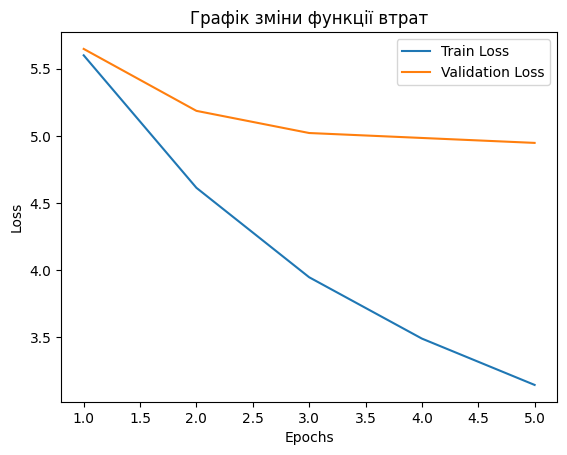

In [30]:
# Візуалізуємо функції втрат
epochs = range(1, n_epochs + 1)

plt.plot(epochs, train_losses, label='Train Loss')
plt.plot(epochs, valid_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Графік зміни функції втрат')
plt.show()


## Приклади перекладу

In [31]:
# Функція перекладу
def translate_sentence(
    sentence, 
    model,
    en_nlp,
    pl_nlp,
    en_vocab,
    pl_vocab,
    lower,
    sos_token,
    eos_token,
    device,
    max_output_length=25,
):
    model.eval()
    with torch.no_grad():
        if isinstance(sentence, str):
            pl_tokens = [token.text for token in pl_nlp.tokenizer(sentence)]
        else:
            pl_tokens = [token for token in sentence]
        if lower:
            pl_tokens = [token.lower() for token in pl_tokens]
        pl_tokens = [sos_token] + pl_tokens + [eos_token]
        ids = pl_vocab.lookup_indices(pl_tokens)
        tensor = torch.LongTensor(ids).unsqueeze(-1).to(device)
        encoder_outputs, hidden = model.encoder(tensor)
        inputs = en_vocab.lookup_indices([sos_token])
        attentions = torch.zeros(max_output_length, 1, len(ids))
        for i in range(max_output_length):
            inputs_tensor = torch.LongTensor([inputs[-1]]).to(device)
            output, hidden, attention = model.decoder(inputs_tensor, hidden, encoder_outputs)
            attentions[i] = attention
            predicted_token = output.argmax(-1).item()
            inputs.append(predicted_token)
            if predicted_token == en_vocab[eos_token]:
                break
        en_tokens = en_vocab.lookup_tokens(inputs)
    return en_tokens, pl_tokens, attentions[:len(en_tokens)-1]

In [32]:
sentence = valid_data[0]["translation"]["pl"]
expected_translation = train_data[0]["translation"]["en"]

sentence, expected_translation

('Jesteśmy czołowym ofiarodawcą pomocy rozwojowej i humanitarnej.',
 'At the same time, we have reason to be cautious when it comes to harmonising criminal law, not least in an area which has constitutional implications.')

In [33]:
translation, sentence_tokens, attention = translate_sentence(
    sentence,
    model,
    en_nlp,
    pl_nlp,
    en_vocab,
    pl_vocab,
    lower,
    sos_token,
    eos_token,
    device,
)

print(translation)
print(sentence_tokens)

['<sos>', 'we', 'are', '<unk>', '<unk>', '<unk>', 'of', 'humanitarian', 'aid', 'and', 'humanitarian', 'aid', '.', '<eos>']
['<sos>', 'jesteśmy', 'czołowym', 'ofiarodawcą', 'pomocy', 'rozwojowej', 'i', 'humanitarnej', '.', '<eos>']


In [37]:
# Порівняємо результат з еталонним перекладом
from nltk.translate.bleu_score import sentence_bleu

reference = expected_translation.split()
candidate = translation[1:-1]
score = sentence_bleu([reference], candidate)
print(f"BLEU score: {score:.2f}")

BLEU score: 0.17


In [34]:
#  Візуалізація механізму уваги
def plot_attention(sentence, translation, attention):
    fig, ax = plt.subplots(figsize=(8,8))
    attention = attention.squeeze(1).numpy()
    cax = ax.matshow(attention, cmap="bone")
    ax.set_xticks(ticks=np.arange(len(sentence)))
    ax.set_xticklabels(sentence, rotation=90, fontsize=8)
    translation = translation[1:]
    ax.set_yticks(ticks=np.arange(len(translation)))
    ax.set_yticklabels(translation, fontsize=8)
    
    plt.show()
    plt.close()

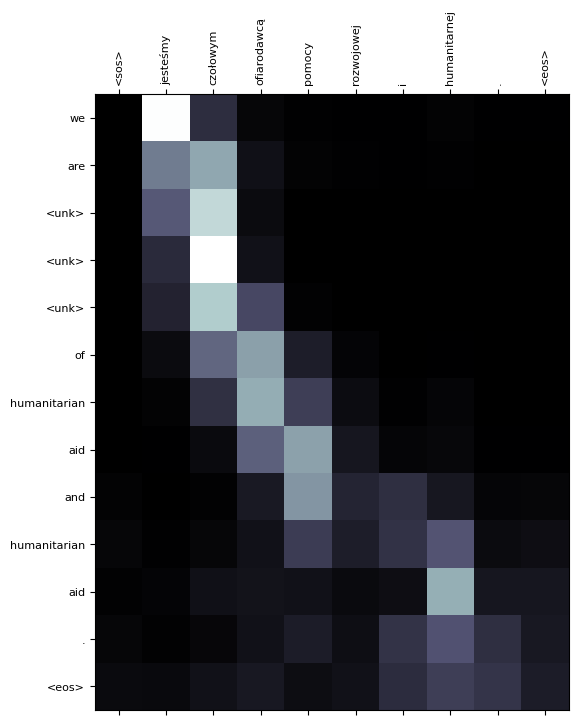

In [35]:
plot_attention(sentence_tokens, translation, attention)

## Аналіз та інтерпретація

**Train Loss** стабільно знижується, що вказує на те, що модель навчається. **Validation Loss** майже не зменшується після кількох епох, що вказує на те, що модель не може повністю узагальнити валідаційні дані. Це вказує на можливе недонавчання.

На **матриці уваги** видно чіткі діагональні шаблони, що вказує на те, що модель навчилася знаходити правильні зв'язки між словами в реченнях. Проте видно кілька <unk> токенів, що означає погану обробку деяких слів. Можливо, в наборі даних багато рідкісних слів або слова не покриваються словником.
    
**Сильні сторони:** модель демонструє поступове покращення на тренувальних даних, що вказує на те, що вона здатна навчатися.
Механізм уваги працює, оскільки матриця показує правильні відповідності між джерельними та цільовими реченнями.
    
**Слабкі сторони:** валідаційні втрати майже не покращуються, що може вказувати на те, що модель недостатньо навчається або є недостача даних. Присутність <unk> токенів означає, що словник може бути занадто малий або моделі не вистачає інформації про рідкісні слова. Я вважаю, це через те, що ми використовували всього 10% датасету.